In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        dout = nn.Dropout(0.1)
        self.conv1 = nn.Sequential(
          nn.Conv2d(1, 16, 3),
          nn.ReLU(),
          nn.BatchNorm2d(16),
          dout
        ) #26
        self.conv2 = nn.Sequential(
          nn.Conv2d(16, 32, 3),
          nn.ReLU(),
          nn.BatchNorm2d(32),
          dout
        ) #24
        
        self.conv3 = nn.Conv2d(32,10,1) #24

        self.pool1 = nn.MaxPool2d(2,2) #12

        self.conv4 = nn.Sequential(
          nn.Conv2d(10, 10, 3),
          nn.ReLU(),
          nn.BatchNorm2d(10),
          dout
        ) #10
        
        self.conv5 = nn.Sequential(
          nn.Conv2d(10, 16, 3),
          nn.ReLU(),
          nn.BatchNorm2d(16),
          dout
        ) #8
        
        self.conv6 = nn.Sequential(
          nn.Conv2d(16, 16, 3),
          nn.ReLU(),
          nn.BatchNorm2d(16),
          dout
        ) #6
        
        self.conv7 = nn.Sequential(
          nn.Conv2d(16, 16, 3),
          nn.ReLU(),
          #nn.BatchNorm2d(16),
          dout
        ) #4
        
        self.conv8 = nn.Sequential(
          nn.Conv2d(16, 10, 4),
          #nn.ReLU(),
          #nn.BatchNorm2d(10),
          dout          
        ) #1
        


    def forward(self, x):
        x = self.conv1(x)  # i = 28  o = 26  RF= 3
        x = self.conv2(x)  # i = 26  o = 24  RF= 5
        x = self.conv3(x)  # i = 24  o = 24  RF= 5
        x = self.pool1(x)  # i = 24  o = 12  RF= 10
        x = self.conv4(x)  # i = 12  o = 10  RF= 12
        x = self.conv5(x)  # i = 10  o = 8   RF= 14
        #x = self.pool1(x)
        x = self.conv6(x)  # i = 8  o = 6  RF= 16
        x = self.conv7(x)  # i = 6  o = 4  RF= 18
        x = self.conv8(x)  # i = 4  o = 1  RF= 20
        #set_trace()
        x = x.view(-1, 10)
        #return F.log_softmax(x)
        #nn.Flatten(x)
        return F.softmax(x)


In [3]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

C:\Users\skanukollu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
           Dropout-5           [-1, 16, 26, 26]               0
           Dropout-6           [-1, 16, 26, 26]               0
           Dropout-7           [-1, 16, 26, 26]               0
           Dropout-8           [-1, 16, 26, 26]               0
           Dropout-9           [-1, 16, 26, 26]               0
          Dropout-10           [-1, 16, 26, 26]               0
           Conv2d-11           [-1, 32, 24, 24]           4,640
             ReLU-12           [-1, 32, 24, 24]               0
      BatchNorm2d-13           [-1, 32, 24, 24]              64
          Dropout-14           [-1, 32,

In [4]:

torch.manual_seed(1)
batch_size = 128


kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('.', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('.', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

torch.Size([128, 1, 28, 28])
torch.Size([128])


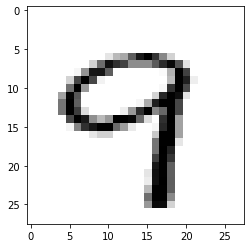

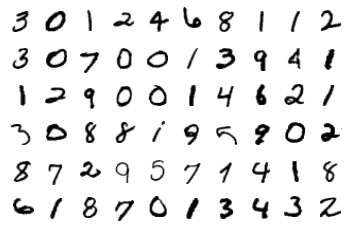

In [5]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')




In [6]:
criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)

#logps = model(images) #log probabilities
#loss = criterion(logps, labels) #calculate the NLL loss

In [ ]:
from tqdm import tqdm
log_interval = 10
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        #set_trace()
        
        optimizer.zero_grad()
        output = model(data)
        
        loss = F.nll_loss(output, target)
        #loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
    
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            #test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

for epoch in range(1, 6):
    #set_trace()
    print('\n##### Epoch Number : %d ######'%epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

In [ ]:
torch.save(model.state_dict(),'mnist_v2.pt')

In [7]:
chkpnt = torch.load('mnist_v2.pt')
chkpnt.keys()

odict_keys(['conv1.0.weight', 'conv1.0.bias', 'conv1.2.weight', 'conv1.2.bias', 'conv1.2.running_mean', 'conv1.2.running_var', 'conv1.2.num_batches_tracked', 'conv2.0.weight', 'conv2.0.bias', 'conv2.2.weight', 'conv2.2.bias', 'conv2.2.running_mean', 'conv2.2.running_var', 'conv2.2.num_batches_tracked', 'conv3.weight', 'conv3.bias', 'conv4.0.weight', 'conv4.0.bias', 'conv4.2.weight', 'conv4.2.bias', 'conv4.2.running_mean', 'conv4.2.running_var', 'conv4.2.num_batches_tracked', 'conv5.0.weight', 'conv5.0.bias', 'conv5.2.weight', 'conv5.2.bias', 'conv5.2.running_mean', 'conv5.2.running_var', 'conv5.2.num_batches_tracked', 'conv6.0.weight', 'conv6.0.bias', 'conv6.2.weight', 'conv6.2.bias', 'conv6.2.running_mean', 'conv6.2.running_var', 'conv6.2.num_batches_tracked', 'conv7.0.weight', 'conv7.0.bias', 'conv8.0.weight', 'conv8.0.bias'])

In [8]:
dep_model = Net().to(device)
dep_model.load_state_dict(chkpnt)
dep_model.eval()

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (conv3): Conv2d(32, 10, kernel_size=(1, 1), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (conv5): Sequential(
    (0): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True

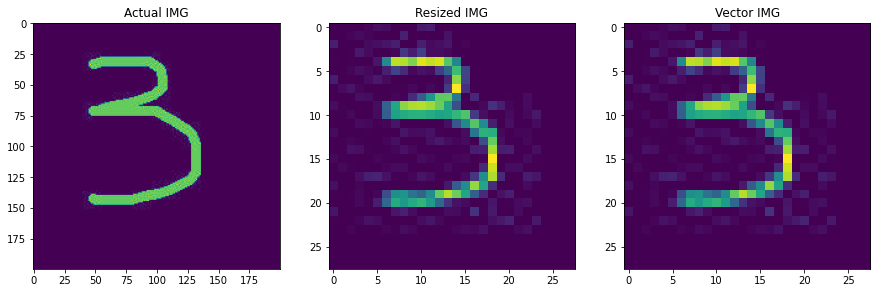

In [21]:
from PIL import Image
r_img = Image.open('resized.jpeg')
A_img = Image.open('ActualImg.jpeg')
v_img = Image.open('vect.jpeg')


fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(A_img)
ax[0].set_title("Actual IMG");

ax[1].imshow(r_img)
ax[1].set_title("Resized IMG");

ax[2].imshow(r_img)
ax[2].set_title("Vector IMG");

In [11]:
from torchvision import transforms
img_t = transforms.ToTensor()(r_img)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_t = img_t.to(device)
print(f'### Tensor Img shape is : {img_t.shape}')

### Tensor Img shape is : torch.Size([1, 28, 28])


In [20]:
dep_model(img_t.unsqueeze(0)).argmax()

C:\Users\skanukollu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(8)

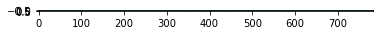

In [19]:
img_pil = transforms.ToPILImage()
plt.imshow(img_pil(images[0].unsqueeze(0)))

In [ ]:
img_t.unsqueeze(0).numpy().shape

In [14]:
28*28

784